In [2]:
import numpy as np
from astropy.io import fits
from astropy.table import Table as Table
import matplotlib.pyplot as plt
from linetools.spectra import utils as ltsu
from linetools.spectra.xspectrum1d import XSpectrum1D
import astropy.units as u
from astropy import constants as const

In [3]:
#to order and match the spec with their z values
spec_atr = Table.read('/home/jsm/PycharmProjects/Summer_Research_2018/new_spec/cl2017_redux/cl2017_valueadded_release_20171009.txt', format = 'ascii') 

#an initial filter to ensure the spec included cover lya
basestring = '/home/jsm/PycharmProjects/Summer_Research_2018/new_spec/cl2017_redux/spec_v0/'

init_spec = []

init_z = []
    
for entry in spec_atr:
    
    if 2.00 < entry["col5"] < 2.9: 
        
        temp = XSpectrum1D.from_file(basestring + entry["col1"])
        
        if temp.wvmin < (1216*u.AA)*(1+entry["col5"]) < temp.wvmax:
                
            init_z.append(entry["col5"])
                
            init_spec.append(XSpectrum1D.from_file(basestring + entry["col1"]))

/home/jsm/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in greater
  *arrays, **kwargs)


In [4]:
#spec_atr

In [5]:
init_spec = np.asarray(init_spec)

print("Number of spectra (Nspec) after filter =", len(init_spec))

init_z = np.asarray(init_z)

yeet = 2.4573692307692312

4200/(1+yeet)

Number of spectra (Nspec) after filter = 352


1214.796488214694

In [6]:
wave_range_mask = [(3600*u.AA > spec.wvmin) and (4600*u.AA < spec.wvmax) for spec in init_spec]

speclist = init_spec[wave_range_mask]

print(len(speclist))

z_val = init_z[wave_range_mask]

128


In [7]:
wave = np.linspace(3140,4200)

s2n = []

for i in range(len(speclist)):
    
    s2n.append ( [XSpectrum1D.get_local_s2n(speclist[i],wavelength*u.AA)[0] for wavelength in wave] )

In [8]:
s2n_mean = []

s2n_med = []

for i in s2n:
    
    s2n_mean.append(np.mean(i))
    
    s2n_med.append(np.median(i))
    
s2n_min = 2.5

In [9]:
#an array to match the spectra with their s2n values
trim = np.asarray([speclist, s2n_mean]).T  

np.shape(trim)
    
#grabbing only those above the min value
trimmed_spec = trim[trim[:, 1] > s2n_min][:, 0]  


#to match the new list with z values
trimmed_z = z_val[trim[:, 1] > s2n_min]

In [10]:
#normalizing the flux
flux_med = [np.median(trimmed_spec[i].flux) for i in range(len(trimmed_spec))]

scaled_flux = np.asarray([(trimmed_spec[i].flux/flux_med[i]) for i in range(len(trimmed_spec))])

#print(len(scaled_flux[0]))

scaled_spec = []

#the new scaled Xspec objects
for i in range(len(trimmed_spec)):       
    
    scaled_spec.append(XSpectrum1D(trimmed_spec[i].wavelength,scaled_flux[i],sig=trimmed_spec[i].sig))

/home/jsm/PycharmProjects/Summer_Research_2018/linetools/linetools/spectra/xspectrum1d.py:254: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


In [11]:
#waverange=(3500,4500)
#for j in scaled_spec:
    
#    j.plot(xlim=waverange)
#    plt.show()

In [12]:
#the final trim on the wavelegth array to ensure a solid stack
new_spec = []

for i in range(len(scaled_spec)):       
    
    new_spec.append(XSpectrum1D(scaled_spec[i].data["wave"][0][640:1460],
                                scaled_spec[i].data["flux"][0][640:1460],
                                scaled_spec[i].data["sig"][0][640:1460]))

collate = ltsu.collate(new_spec)

print(collate.nspec,len(trimmed_z))

np.average(trimmed_z)

14 14


/home/jsm/PycharmProjects/Summer_Research_2018/linetools/linetools/spectra/xspectrum1d.py:254: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


2.5290714285714286

In [19]:
#rest frame wave values
#rest_spec = ltsu.rebin_to_rest(collate, trimmed_z, 200*u.km/u.s ,grow_bad_sig=True)

spec = collate
zarr = trimmed_z
dv = 200*u.km/u.s

dlnlamb = np.log(1+dv/const.c)
z2d = np.outer(zarr, np.ones(spec.totpix))
wvmin, wvmax = (np.min(spec.data['wave']/(1+z2d))*spec.units['wave'],
                np.max(spec.data['wave']/(1+z2d))*spec.units['wave'])

wvmin

<Quantity 941.0626469078996 Angstrom>

In [16]:
#the stack!
stack = ltsu.smash_spectra(rest_spec)

stack.plot()#(xlim=(1000,1200))
plt.show()

Using matplotlib backend: Qt5Agg


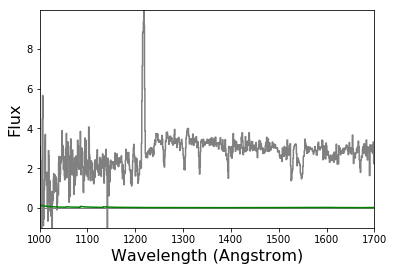

In [30]:
yeet = XSpectrum1D.from_file("/home/jsm/Downloads/fullstack.fits")

yeet.plot(xlim=(1000,1700))

In [ ]:
#stack.write_to_fits("fullstack36.fits")